**Todo**:
1. Transform features (must understand the sensor data before
2. Remove unnecessary features (using what? correlation matrix, random forest, pca, ...)
3. Combine different regression models (ensemble model) to evaluate the test dataset
3. Try Deep Learning (Autoencoder, Vanilla... on google colab or on gpu server if you have an access)
4. Look into paperswithcode website for experimental model
5. Think about how to make a learning model explainable for decision
6. Do some EDAs, don't have to be fancy or anything
7. Post random code on the dacon website; uploading a code is part of the grade 


possibly more...

### Import Libraries

In [7]:
import pandas as pd
import random
import os
import numpy as np
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
from lightgbm import LGBMRegressor
from hyperopt import fmin, hp, tpe, atpe
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

### Usable Functions 

In [9]:
def dataset_split_X_y(df):    
    """
    @Description: split data into features and labels
    @Param: df, pandas dataframe with columns starting with X for features and Y for labels
    @Return: features and labels in pandas dataframes
    """
    xs = df.filter(regex='X') # Input : X Featrue
    ys = df.filter(regex='Y') # Output : Y Feature
    return xs, ys

In [10]:
def check_for_NAs(df, show=False):
    """
    @Description: checks for the NAs in the dataframe
    @Param1: df, pandas dataframe
    @Param2: show, boolean indicating whether NaN data are also necessary as a part of the output
    @Return: name of the columns with NaN
    """
    nan_values = df.loc[:, df.isnull().any()]
    if show:
        return df[df.isna().any(axis=1)]
    return list(nan_values.columns)

In [11]:
def check_for_label_bound(df, labels, bound):
    """
    @Description: check bound is inbetween min and max
    @Param1: df, pandas dataframe
    @Param2: labels, list of column names 
    @Param3: thres: list of bounds
    @Return: names of the columns not within the bound
    """
    n = len(labels)
    result = []
    for idx in range(n):
        col = labels[idx]
        thres = bound[idx]
        extracted_column = df[col]
        if not extracted_column.between(thres[0], thres[1]).all():
            result.append(labels[idx])
    if len(result) == 0:
        print('everything is within the bound')
    return result

In [12]:
def zero_variance(df):
    """
    @Description: check for zero_variance
    @Param1: df, pandas dataframe
    @Return: names of the columns with zero variance
    """
    result = []
    for col in train_x.columns:
        if train_x[col].var() == 0:
            result.append(col)
    return result

In [13]:
def get_top_correlation(df, n=10):
    """
    @Description: print out top correlated features
    @Param1: df, pandas dataframe
    @Param2: n, number of lines to print 
    @Return: pandas series
    """
    pairs = set()
    for idx1 in range(0, df.shape[1]):
        for idx2 in range(0, idx1+1):
            pairs.add((df.columns[idx1], df.columns[idx2]))
    corr = df.corr().abs().unstack()
    corr = corr.drop(labels=pairs).sort_values(ascending=False)
    return corr[0:n]

In [14]:
def adjacent_histogram_boxplot(feature_var, figsize = (7, 5)):
    """
    @Description: plot histogram and boxplot in next to each other
    @Param1: feature_var, pandas series 
    @Param2: figsize, size of the figure 
    """
    fig, (hist_plot, box_plot) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios':(.85,.15)}, figsize=figsize)
    sns.distplot(feature_var, kde=True, ax=hist_plot, kde_kws= {"linewidth":1.5}) 
    sns.boxplot(feature_var, ax=box_plot, linewidth = 1, width = 0.5)
    hist_plot.set_ylabel('')    
    hist_plot.set_xlabel('')
    box_plot.set_xlabel('')
    hist_plot.tick_params(labelsize=8)
    box_plot.tick_params(labelsize=8)
    fig.suptitle(feature_var.name, fontsize = 10)
    hist_plot.axvline(np.mean(feature_var),color='red',linestyle='-',lw = 1.5)
    hist_plot.axvline(np.median(feature_var),color='green',linestyle='--',lw = 1.5)
    

In [15]:
def lg_nrmse(gt, preds):
    """
    @Description: Metric used in this project
    @Params1: gt, pandas dataframe
    @Param2: preds, pandas dataframe
    @Return: nrmse score
    """
    # 각 Y Feature별 NRMSE 총합
    # Y_01 ~ Y_08 까지 20% 가중치 부여
    preds = pd.DataFrame(preds)
    all_nrmse = []
    for idx in range(0,14):
        rmse = mean_squared_error(gt.iloc[:,idx], preds.iloc[:,idx], squared=False)
        nrmse = rmse/np.mean(np.abs(gt.iloc[:,idx]))
        all_nrmse.append(nrmse)
    score = 1.2 * np.sum(all_nrmse[:8]) + 1.0 * np.sum(all_nrmse[8:15])
    return score

In [16]:
# ys = ['Y_01', 'Y_02', 'Y_03', 'Y_04', 'Y_05', 
#       'Y_06', 'Y_07', 'Y_08', 'Y_09', 'Y_10', 
#       'Y_11', 'Y_12', 'Y_13', 'Y_14']
# ys_bounds = [[0.2, 2], [0.2, 2.1], [0.2, 2.1], 
#              [7, 19], [22, 36.5], [-19.2, 19], 
#              [2.4, 4], [-29.2, -24], [-29.2, -24],
#              [-30.6, -20], [19.6, 26.6], [-29.2, -24],
#              [-29.2, -24], [-29.2, -24]]

### Load Dataset

In [76]:
train_df = pd.read_csv('data/train.csv')
test_x = pd.read_csv('data/test.csv')
train_x, train_y = dataset_split_X_y(train_df)

In [77]:
# traing1 (train group) > PCB 체결 시 단계별 누름량(Step 1 ~ 4)

In [78]:
train_g1 = pd.concat([train_x.iloc[:, 4:6],train_x.iloc[:, :2]],axis=1)

In [79]:
train_g1.head()

,X_05,X_06,X_01,X_02
0,101.892,74.983,70.544,103.320
1,101.944,72.943,69.524,103.321
2,103.153,72.943,72.583,103.320
3,101.971,77.022,71.563,103.320
4,101.981,70.904,69.524,103.320


In [80]:
# traing1 (train group) > 방열 재료 무게 (1 ~ 3)

In [81]:
train_g2 = pd.concat([train_x.iloc[:, 2:3],train_x.iloc[:, 9:11]],axis=1)

In [82]:
train_g2.head()

,X_03,X_10,X_11
0,67.47,0.0,0.0
1,65.17,0.0,0.0
2,64.07,0.0,0.0
3,67.57,0.0,0.0
4,63.57,0.0,0.0


In [83]:
# traing1 (train group) > 방열 재료 면적 (1 ~ 3)

In [84]:
train_g3 = train_x.iloc[:, 6:9]

In [85]:
train_g3.head()

,X_07,X_08,X_09
0,29.45,62.38,245.71
1,28.73,61.23,233.61
2,28.81,105.77,272.20
3,28.92,115.21,255.36
4,29.68,103.38,241.46


In [86]:
# traing1 (train group) > 안테나 패드 위치 (1 ~ 5)

In [95]:
train_g4 = train_x.iloc[:, 13:18]

In [96]:
train_g4.head()

,X_14,X_15,X_16,X_17,X_18
0,13.34,13.37,13.40,13.52,13.44
1,13.33,13.33,13.46,13.51,13.42
2,13.36,13.36,13.39,13.51,13.43
3,13.30,13.33,13.39,13.51,13.40
4,13.35,13.34,13.41,13.50,13.42


In [ ]:
# traing1 (train group) > 커넥터 n번 핀 치수 (1 ~ 6)

In [92]:
train_g5 = train_x.iloc[:, 23:29]

In [93]:
train_g5.head()

,X_24,X_25,X_26,X_27,X_28,X_29
0,2.05,2.07,2.05,2.06,2.06,2.35
1,2.10,2.10,2.10,2.10,2.17,2.28
2,2.07,2.06,2.04,2.07,2.10,2.26
3,2.06,2.05,2.03,2.06,2.07,2.12
4,2.09,2.06,2.09,2.12,2.33,2.13


In [ ]:
# traing1 (train group) > 스크류 체결 시 분당 회전수  (1 ~ 4)

In [97]:
train_g6 = train_x.iloc[:, 33:37]

In [98]:
train_g6.head()

,X_34,X_35,X_36,X_37
0,12.99,12.88,12.89,12.99
1,12.92,12.87,12.89,12.93
2,12.97,12.87,12.87,13.00
3,12.91,12.97,12.99,12.92
4,12.96,12.85,12.91,12.96


In [ ]:
# traing1 (train group) > 하우징 PCB 안착부 치수  (1 ~ 3)

In [99]:
train_g7 = train_x.iloc[:, 37:40]

In [100]:
train_g7.head()

,X_38,X_39,X_40
0,-16.41,-16.36,-17.03
1,-16.06,-16.11,-16.74
2,-16.16,-16.17,-16.76
3,-16.05,-16.03,-16.67
4,-16.25,-16.23,-16.85


In [101]:
# traing1 (train group) > 레이돔 치수 (안테나 1번 부위)  (1 ~ 4)

In [104]:
train_g8 = train_x.iloc[:, 40:44]

In [105]:
train_g8.head()

,X_41,X_42,X_43,X_44
0,21.20,20.99,21.28,21.09
1,21.16,21.03,21.16,21.13
2,21.13,21.03,21.17,21.12
3,21.18,20.98,21.20,21.09
4,21.16,20.96,21.18,21.10


In [ ]:
# traing1 (train group) > RF1 부분 SMT 납 량 (1 ~ 7)

In [106]:
train_g9 = train_x.iloc[:, 49:56]

In [107]:
train_g9.head()

,X_50,X_51,X_52,X_53,X_54,X_55,X_56
0,137.043591,135.359219,147.837968,134.313475,125.605427,136.721425,125.028256
1,133.736691,135.979817,149.924692,123.630583,127.893337,143.322659,124.877308
2,132.805112,131.055355,146.814592,128.939070,127.012195,140.395688,122.238232
3,134.138760,133.239422,139.720132,132.260824,130.723186,147.624829,134.875225
4,142.728970,136.620022,134.853555,134.760252,125.647793,139.331105,123.272762


In [135]:
train_g10 = pd.concat([train_g4, train_g7],axis=1)
train_g10 = pd.concat([train_g9, train_g10],axis=1)

### Exploratory Data Analysis

In [29]:
train_x.iloc[:, :10].describe()

,X_01,X_02,X_03,X_04,X_05,X_06,X_07,X_08,X_09,X_10
count,39607.000000,39607.000000,39607.000000,39607.0,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000
mean,68.412040,103.320166,68.826354,1.0,102.337203,70.597211,29.407490,164.449320,225.397470,0.002449
std,2.655983,0.000372,5.151167,0.0,0.548353,2.259820,7.338204,220.402444,66.734725,0.086255
min,56.268000,103.320000,56.470000,1.0,101.774000,61.726000,14.140000,38.460000,37.580000,0.000000
25%,66.465000,103.320000,65.070000,1.0,101.949000,68.864000,27.890000,105.990000,188.540000,0.000000
50%,68.504000,103.320000,67.270000,1.0,102.006000,69.884000,28.840000,115.040000,234.450000,0.000000
75%,69.524000,103.320000,71.770000,1.0,103.144000,71.923000,29.870000,132.620000,263.960000,0.000000
max,84.820000,103.321000,89.170000,1.0,103.160000,87.219000,163.860000,2387.440000,637.490000,3.600000


C:\Users\dlwl9\anaconda3\envs\dacon\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\dlwl9\anaconda3\envs\dacon\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


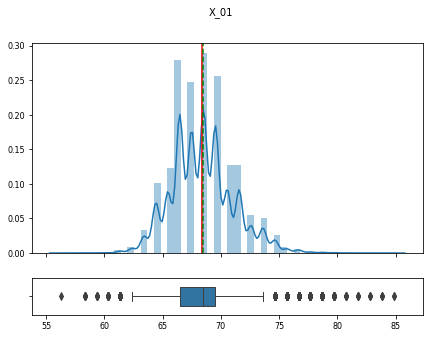

In [30]:
x01 = train_x.iloc[:, :10].iloc[:, 0]
adjacent_histogram_boxplot(x01)

In [31]:
train_x.iloc[:, 10:20].describe()

,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20
count,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000
mean,0.000366,4.373228,0.143335,13.372201,13.381914,13.463860,13.512589,13.449263,3.240229,3.184493
std,0.014145,0.021806,0.025334,0.029865,0.029468,0.036741,0.023436,0.029093,0.110482,0.105266
min,0.000000,4.270000,0.050000,13.150000,13.230000,13.260000,13.410000,13.260000,2.860000,2.830000
25%,0.000000,4.360000,0.130000,13.350000,13.360000,13.440000,13.500000,13.430000,3.160000,3.100000
50%,0.000000,4.370000,0.140000,13.370000,13.380000,13.470000,13.510000,13.450000,3.220000,3.180000
75%,0.000000,4.390000,0.160000,13.390000,13.410000,13.490000,13.530000,13.470000,3.310000,3.270000
max,0.700000,4.490000,0.280000,13.490000,13.500000,13.610000,13.610000,13.570000,3.750000,3.670000


In [32]:
train_x.iloc[:, 20:30].describe()

,X_21,X_22,X_23,X_24,X_25,X_26,X_27,X_28,X_29,X_30
count,39607.000000,39607.000000,39607.0,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000
mean,3.174270,3.232673,1.0,2.115674,2.093895,2.090377,2.098249,2.118594,2.173727,1.378994
std,0.106868,0.108981,0.0,0.032440,0.033148,0.038512,0.038056,0.042782,0.046689,0.030412
min,2.830000,2.850000,1.0,1.830000,1.960000,1.980000,1.990000,1.930000,2.020000,0.570000
25%,3.090000,3.140000,1.0,2.090000,2.070000,2.060000,2.070000,2.090000,2.140000,1.370000
50%,3.160000,3.230000,1.0,2.120000,2.090000,2.090000,2.090000,2.120000,2.170000,1.370000
75%,3.250000,3.320000,1.0,2.140000,2.120000,2.120000,2.120000,2.140000,2.200000,1.380000
max,3.680000,3.790000,1.0,2.350000,2.350000,2.350000,2.350000,2.350000,2.360000,2.110000


In [33]:
train_x.iloc[:, 30:40].describe()

,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,X_40
count,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000
mean,1.571141,1.362929,1.595723,12.950271,12.920343,12.941728,12.919139,-15.903737,-15.889576,-16.572162
std,0.074520,0.029945,0.108028,0.044030,0.052238,0.047830,0.052292,0.595420,0.746665,0.344486
min,0.600000,0.570000,0.610000,12.840000,12.810000,12.840000,12.810000,-17.090000,-17.090000,-17.720000
25%,1.530000,1.350000,1.550000,12.920000,12.870000,12.900000,12.870000,-16.160000,-16.160000,-16.810000
50%,1.550000,1.360000,1.570000,12.960000,12.920000,12.950000,12.910000,-15.990000,-15.990000,-16.640000
75%,1.600000,1.370000,1.610000,12.990000,12.970000,12.980000,12.970000,-15.750000,-15.750000,-16.400000
max,7.210000,2.450000,7.810000,13.080000,13.090000,13.090000,13.080000,32.230000,-2.650000,-14.800000


In [34]:
train_x.iloc[:, 40:50].describe()

,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50
count,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.0,39607.0,39607.000000,39607.000000
mean,21.186992,21.059334,21.203705,21.160107,0.154567,1468.275305,1.0,1.0,16676.913639,130.774557
std,0.031128,0.040288,0.047211,0.042176,0.046968,2.121517,0.0,0.0,8584.427420,5.989845
min,20.730000,20.790000,20.800000,20.930000,0.000000,1457.000000,1.0,1.0,3341.830000,21.800000
25%,21.170000,21.030000,21.170000,21.130000,0.120000,1469.000000,1.0,1.0,13093.930000,126.948571
50%,21.190000,21.060000,21.200000,21.160000,0.150000,1469.000000,1.0,1.0,15273.330000,130.723378
75%,21.210000,21.090000,21.240000,21.190000,0.190000,1469.000000,1.0,1.0,17560.180000,134.538998
max,21.620000,21.440000,21.410000,21.320000,0.420000,1469.000000,1.0,1.0,114563.630000,162.619458


In [35]:
train_x.iloc[:, 50:].describe()

,X_51,X_52,X_53,X_54,X_55,X_56
count,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000
mean,131.457418,138.587595,127.992420,128.014110,137.884711,128.441119
std,5.934313,6.469813,5.713153,5.433958,6.552101,5.444245
min,21.910000,23.100000,21.330000,21.340000,22.980000,21.410000
25%,127.669758,134.475401,124.374525,124.697879,133.744103,125.134713
50%,131.352856,138.525575,128.020010,128.098728,137.900952,128.414501
75%,135.170761,142.702448,131.618662,131.487423,142.073102,131.839764
max,194.513195,173.438623,152.406630,175.052891,170.155980,155.277538


### Feature Selection
Need to spend more time on this!  

Must understand the nature of the data (sensor) to get better performance

In [36]:
cols_with_zero_variance = zero_variance(train_x)
train_x = train_x.drop(cols_with_zero_variance, axis = 1)

test_x = test_x.drop(cols_with_zero_variance, axis = 1)

highly_correlated = [i[1] for i in get_top_correlation(train_x, 7).index]
train_x = train_x.drop(highly_correlated, axis = 1)

test_x = test_x.drop(highly_correlated, axis = 1)
test_x = test_x.drop('ID', axis=1)

In [56]:
train_x = train_g1

In [108]:
train_x = train_g2

In [111]:
train_x = train_g3

In [114]:
train_x = train_g4

In [117]:
train_x = train_g5

In [121]:
train_x = train_g6

In [124]:
train_x = train_g7

In [127]:
train_x = train_g8

In [129]:
train_x = train_g9

In [136]:
train_x = train_g10

### Train
Train dataset is again splitted into train and validation set

In [57]:
def evaluate(params, x_train, y_train, x_test, y_test):
    model = MultiOutputRegressor(LGBMRegressor(objective='regression', n_jobs=-1, **params))
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    nrmse = lg_nrmse(y_test, pred)
    return nrmse

In [137]:
train_X, validation_X, train_Y, validation_Y = train_test_split(train_x, train_y, test_size = 0.2, )


In [59]:
lgb_params_space = {
    'max_depth':        hp.choice('max_depth',        np.arange(3, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 9, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.2, 0.9, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'feature_fraction': hp.uniform('feature_fraction', 0.5, 1),
    'n_estimators':     100,
    'num_leaves':       50,
    'bagging_fraction': hp.uniform("bagging_fraction", 0, 1.0),
}

In [60]:
# train group1
hyperopt_objective = lambda params: evaluate(params, train_X, train_Y, validation_X, validation_Y)
best_params = fmin(hyperopt_objective, space=lgb_params_space, algo = atpe.suggest, max_evals=30)

[LightGBM] [Warning] feature_fraction is set=0.6982587207191818, colsample_bytree=0.30000000000000004 will be ignored. Current value: feature_fraction=0.6982587207191818
[LightGBM] [Warning] bagging_fraction is set=0.0011285451202917018, subsample=0.9686912083906067 will be ignored. Current value: bagging_fraction=0.0011285451202917018
[LightGBM] [Warning] feature_fraction is set=0.7817001613248781, colsample_bytree=0.2 will be ignored. Current value: feature_fraction=0.7817001613248781
[LightGBM] [Warning] bagging_fraction is set=0.8302429796162439, subsample=0.9284280818874809 will be ignored. Current value: bagging_fraction=0.8302429796162439
[LightGBM] [Warning] feature_fraction is set=0.5522360379929485, colsample_bytree=0.5000000000000001 will be ignored. Current value: feature_fraction=0.5522360379929485
[LightGBM] [Warning] bagging_fraction is set=0.9255272833511949, subsample=0.8366135601231823 will be ignored. Current value: bagging_fraction=0.9255272833511949
[LightGBM] [War

[LightGBM] [Warning] bagging_fraction is set=0.1364614640666727, subsample=0.9646861709656662 will be ignored. Current value: bagging_fraction=0.1364614640666727
[LightGBM] [Warning] feature_fraction is set=0.6002192306555811, colsample_bytree=0.30000000000000004 will be ignored. Current value: feature_fraction=0.6002192306555811
[LightGBM] [Warning] bagging_fraction is set=0.1933978011079503, subsample=0.9436389435565227 will be ignored. Current value: bagging_fraction=0.1933978011079503
[LightGBM] [Warning] feature_fraction is set=0.5907158904163068, colsample_bytree=0.30000000000000004 will be ignored. Current value: feature_fraction=0.5907158904163068
[LightGBM] [Warning] bagging_fraction is set=0.2972583543424221, subsample=0.9380378135056243 will be ignored. Current value: bagging_fraction=0.2972583543424221
[LightGBM] [Warning] feature_fraction is set=0.606711124182317, colsample_bytree=0.30000000000000004 will be ignored. Current value: feature_fraction=0.606711124182317
[Light

In [110]:
# train group2
hyperopt_objective = lambda params: evaluate(params, train_X, train_Y, validation_X, validation_Y)
best_params = fmin(hyperopt_objective, space=lgb_params_space, algo = atpe.suggest, max_evals=30)

[LightGBM] [Warning] feature_fraction is set=0.5372414754573283, colsample_bytree=0.2 will be ignored. Current value: feature_fraction=0.5372414754573283
[LightGBM] [Warning] bagging_fraction is set=0.08438442862645079, subsample=0.9093835782325803 will be ignored. Current value: bagging_fraction=0.08438442862645079
[LightGBM] [Warning] feature_fraction is set=0.5660889953451604, colsample_bytree=0.7000000000000002 will be ignored. Current value: feature_fraction=0.5660889953451604
[LightGBM] [Warning] bagging_fraction is set=0.5062042860618168, subsample=0.9505806913561483 will be ignored. Current value: bagging_fraction=0.5062042860618168
[LightGBM] [Warning] feature_fraction is set=0.5305447146166193, colsample_bytree=0.7000000000000002 will be ignored. Current value: feature_fraction=0.5305447146166193
[LightGBM] [Warning] bagging_fraction is set=0.8228171171545775, subsample=0.8996431460199878 will be ignored. Current value: bagging_fraction=0.8228171171545775
[LightGBM] [Warning]

[LightGBM] [Warning] feature_fraction is set=0.5087766937691278, colsample_bytree=0.6000000000000001 will be ignored. Current value: feature_fraction=0.5087766937691278
[LightGBM] [Warning] bagging_fraction is set=0.6536513839666968, subsample=0.9981893669268027 will be ignored. Current value: bagging_fraction=0.6536513839666968
[LightGBM] [Warning] feature_fraction is set=0.5040960928957894, colsample_bytree=0.6000000000000001 will be ignored. Current value: feature_fraction=0.5040960928957894
[LightGBM] [Warning] bagging_fraction is set=0.64858036403673, subsample=0.997975848650453 will be ignored. Current value: bagging_fraction=0.64858036403673
[LightGBM] [Warning] feature_fraction is set=0.6117649019200578, colsample_bytree=0.8000000000000003 will be ignored. Current value: feature_fraction=0.6117649019200578
[LightGBM] [Warning] bagging_fraction is set=0.6807368115871897, subsample=0.9687133256789445 will be ignored. Current value: bagging_fraction=0.6807368115871897
[LightGBM] [

In [113]:
# train group3
hyperopt_objective = lambda params: evaluate(params, train_X, train_Y, validation_X, validation_Y)
best_params = fmin(hyperopt_objective, space=lgb_params_space, algo = atpe.suggest, max_evals=30)

[LightGBM] [Warning] feature_fraction is set=0.8862609574006142, colsample_bytree=0.4000000000000001 will be ignored. Current value: feature_fraction=0.8862609574006142
[LightGBM] [Warning] bagging_fraction is set=0.4073710412492514, subsample=0.9917106901152977 will be ignored. Current value: bagging_fraction=0.4073710412492514
[LightGBM] [Warning] feature_fraction is set=0.8639653665577638, colsample_bytree=0.7000000000000002 will be ignored. Current value: feature_fraction=0.8639653665577638
[LightGBM] [Warning] bagging_fraction is set=0.9051034251351772, subsample=0.9429607019254138 will be ignored. Current value: bagging_fraction=0.9051034251351772
[LightGBM] [Warning] feature_fraction is set=0.8681693464261953, colsample_bytree=0.6000000000000001 will be ignored. Current value: feature_fraction=0.8681693464261953
[LightGBM] [Warning] bagging_fraction is set=0.7861052798151038, subsample=0.9515935453102289 will be ignored. Current value: bagging_fraction=0.7861052798151038
[LightG

[LightGBM] [Warning] bagging_fraction is set=0.12998714220954885, subsample=0.8646637254639538 will be ignored. Current value: bagging_fraction=0.12998714220954885
[LightGBM] [Warning] feature_fraction is set=0.6204959715041345, colsample_bytree=0.4000000000000001 will be ignored. Current value: feature_fraction=0.6204959715041345
[LightGBM] [Warning] bagging_fraction is set=0.20980485181030517, subsample=0.8895152065454662 will be ignored. Current value: bagging_fraction=0.20980485181030517
[LightGBM] [Warning] feature_fraction is set=0.6926850631317065, colsample_bytree=0.2 will be ignored. Current value: feature_fraction=0.6926850631317065
[LightGBM] [Warning] bagging_fraction is set=0.08573414705421252, subsample=0.8630510105486505 will be ignored. Current value: bagging_fraction=0.08573414705421252
[LightGBM] [Warning] feature_fraction is set=0.6952539132303234, colsample_bytree=0.30000000000000004 will be ignored. Current value: feature_fraction=0.6952539132303234
[LightGBM] [War

In [116]:
# train group4
hyperopt_objective = lambda params: evaluate(params, train_X, train_Y, validation_X, validation_Y)
best_params = fmin(hyperopt_objective, space=lgb_params_space, algo = atpe.suggest, max_evals=30)

[LightGBM] [Warning] feature_fraction is set=0.7989340460030936, colsample_bytree=0.8000000000000003 will be ignored. Current value: feature_fraction=0.7989340460030936
[LightGBM] [Warning] bagging_fraction is set=0.3329986502704936, subsample=0.8754177216221971 will be ignored. Current value: bagging_fraction=0.3329986502704936
[LightGBM] [Warning] feature_fraction is set=0.7890887765453674, colsample_bytree=0.5000000000000001 will be ignored. Current value: feature_fraction=0.7890887765453674
[LightGBM] [Warning] bagging_fraction is set=0.7364561277033999, subsample=0.8168190461764038 will be ignored. Current value: bagging_fraction=0.7364561277033999
[LightGBM] [Warning] feature_fraction is set=0.8018978072452271, colsample_bytree=0.7000000000000002 will be ignored. Current value: feature_fraction=0.8018978072452271
[LightGBM] [Warning] bagging_fraction is set=0.518369370279397, subsample=0.8147894189162532 will be ignored. Current value: bagging_fraction=0.518369370279397
[LightGBM

[LightGBM] [Warning] bagging_fraction is set=0.611855795800888, subsample=0.8128001949659979 will be ignored. Current value: bagging_fraction=0.611855795800888
[LightGBM] [Warning] feature_fraction is set=0.7734976942942513, colsample_bytree=0.4000000000000001 will be ignored. Current value: feature_fraction=0.7734976942942513
[LightGBM] [Warning] bagging_fraction is set=0.5795001681081334, subsample=0.8158157499990459 will be ignored. Current value: bagging_fraction=0.5795001681081334
[LightGBM] [Warning] feature_fraction is set=0.7149791710626164, colsample_bytree=0.4000000000000001 will be ignored. Current value: feature_fraction=0.7149791710626164
[LightGBM] [Warning] bagging_fraction is set=0.7441960400378701, subsample=0.8005239639907081 will be ignored. Current value: bagging_fraction=0.7441960400378701
[LightGBM] [Warning] feature_fraction is set=0.5113676636609833, colsample_bytree=0.4000000000000001 will be ignored. Current value: feature_fraction=0.5113676636609833
[LightGBM

In [120]:
# train group5
hyperopt_objective = lambda params: evaluate(params, train_X, train_Y, validation_X, validation_Y)
best_params = fmin(hyperopt_objective, space=lgb_params_space, algo = atpe.suggest, max_evals=30)

[LightGBM] [Warning] feature_fraction is set=0.7191909813295789, colsample_bytree=0.4000000000000001 will be ignored. Current value: feature_fraction=0.7191909813295789
[LightGBM] [Warning] bagging_fraction is set=0.2649279023539044, subsample=0.8585089133740504 will be ignored. Current value: bagging_fraction=0.2649279023539044
[LightGBM] [Warning] feature_fraction is set=0.7968512255861077, colsample_bytree=0.8000000000000003 will be ignored. Current value: feature_fraction=0.7968512255861077
[LightGBM] [Warning] bagging_fraction is set=0.443024483867246, subsample=0.9556585562913497 will be ignored. Current value: bagging_fraction=0.443024483867246
[LightGBM] [Warning] feature_fraction is set=0.9255812273689281, colsample_bytree=0.30000000000000004 will be ignored. Current value: feature_fraction=0.9255812273689281
[LightGBM] [Warning] bagging_fraction is set=0.27881629193889823, subsample=0.827283123979358 will be ignored. Current value: bagging_fraction=0.27881629193889823
[LightG

[LightGBM] [Warning] feature_fraction is set=0.690625043709383, colsample_bytree=0.2 will be ignored. Current value: feature_fraction=0.690625043709383
[LightGBM] [Warning] bagging_fraction is set=0.5251789440037304, subsample=0.975333178029211 will be ignored. Current value: bagging_fraction=0.5251789440037304
[LightGBM] [Warning] feature_fraction is set=0.6183960186863537, colsample_bytree=0.30000000000000004 will be ignored. Current value: feature_fraction=0.6183960186863537
[LightGBM] [Warning] bagging_fraction is set=0.5079908867156155, subsample=0.9966470649532118 will be ignored. Current value: bagging_fraction=0.5079908867156155
[LightGBM] [Warning] feature_fraction is set=0.6313760479265925, colsample_bytree=0.2 will be ignored. Current value: feature_fraction=0.6313760479265925
[LightGBM] [Warning] bagging_fraction is set=0.3519849244171217, subsample=0.8777278521825499 will be ignored. Current value: bagging_fraction=0.3519849244171217
[LightGBM] [Warning] feature_fraction i

In [123]:
# train group6
hyperopt_objective = lambda params: evaluate(params, train_X, train_Y, validation_X, validation_Y)
best_params = fmin(hyperopt_objective, space=lgb_params_space, algo = atpe.suggest, max_evals=30)

[LightGBM] [Warning] feature_fraction is set=0.8922581470675914, colsample_bytree=0.4000000000000001 will be ignored. Current value: feature_fraction=0.8922581470675914
[LightGBM] [Warning] bagging_fraction is set=0.38384267340513445, subsample=0.9005992419605259 will be ignored. Current value: bagging_fraction=0.38384267340513445
[LightGBM] [Warning] feature_fraction is set=0.7998792151121128, colsample_bytree=0.2 will be ignored. Current value: feature_fraction=0.7998792151121128
[LightGBM] [Warning] bagging_fraction is set=0.028608482425613202, subsample=0.9367631693704448 will be ignored. Current value: bagging_fraction=0.028608482425613202
[LightGBM] [Warning] feature_fraction is set=0.853657921047695, colsample_bytree=0.7000000000000002 will be ignored. Current value: feature_fraction=0.853657921047695
[LightGBM] [Warning] bagging_fraction is set=0.17496693431439125, subsample=0.9476596364714608 will be ignored. Current value: bagging_fraction=0.17496693431439125
[LightGBM] [Warn

job exception: list index out of range



 73%|███████████████████████████████████▏            | 22/30 [00:55<00:20,  2.53s/trial, best loss: 2.0249846800376035]


IndexError: list index out of range

In [126]:
# train group7
hyperopt_objective = lambda params: evaluate(params, train_X, train_Y, validation_X, validation_Y)
best_params = fmin(hyperopt_objective, space=lgb_params_space, algo = atpe.suggest, max_evals=30)

[LightGBM] [Warning] feature_fraction is set=0.5746509736773261, colsample_bytree=0.30000000000000004 will be ignored. Current value: feature_fraction=0.5746509736773261
[LightGBM] [Warning] bagging_fraction is set=0.16450213721506335, subsample=0.8887852497828521 will be ignored. Current value: bagging_fraction=0.16450213721506335
[LightGBM] [Warning] feature_fraction is set=0.5711934206838161, colsample_bytree=0.6000000000000001 will be ignored. Current value: feature_fraction=0.5711934206838161
[LightGBM] [Warning] bagging_fraction is set=0.01514503735135786, subsample=0.9483129413543514 will be ignored. Current value: bagging_fraction=0.01514503735135786
[LightGBM] [Warning] feature_fraction is set=0.8804126946908353, colsample_bytree=0.2 will be ignored. Current value: feature_fraction=0.8804126946908353
[LightGBM] [Warning] bagging_fraction is set=0.6220390147015652, subsample=0.8514586689342147 will be ignored. Current value: bagging_fraction=0.6220390147015652
[LightGBM] [Warni

[LightGBM] [Warning] feature_fraction is set=0.9675470696236645, colsample_bytree=0.30000000000000004 will be ignored. Current value: feature_fraction=0.9675470696236645
[LightGBM] [Warning] bagging_fraction is set=0.17275697861023764, subsample=0.8404981013048819 will be ignored. Current value: bagging_fraction=0.17275697861023764
[LightGBM] [Warning] feature_fraction is set=0.985135532459961, colsample_bytree=0.2 will be ignored. Current value: feature_fraction=0.985135532459961
[LightGBM] [Warning] bagging_fraction is set=0.40083157083424514, subsample=0.8497915055000336 will be ignored. Current value: bagging_fraction=0.40083157083424514
[LightGBM] [Warning] feature_fraction is set=0.9068056202330784, colsample_bytree=0.2 will be ignored. Current value: feature_fraction=0.9068056202330784
[LightGBM] [Warning] bagging_fraction is set=0.10361293187147011, subsample=0.9789673987705091 will be ignored. Current value: bagging_fraction=0.10361293187147011
[LightGBM] [Warning] feature_fra

In [128]:
# train group8
hyperopt_objective = lambda params: evaluate(params, train_X, train_Y, validation_X, validation_Y)
best_params = fmin(hyperopt_objective, space=lgb_params_space, algo = atpe.suggest, max_evals=30)

[LightGBM] [Warning] feature_fraction is set=0.786376254659481, colsample_bytree=0.7000000000000002 will be ignored. Current value: feature_fraction=0.786376254659481
[LightGBM] [Warning] bagging_fraction is set=0.30476918353725224, subsample=0.9666324323233917 will be ignored. Current value: bagging_fraction=0.30476918353725224
[LightGBM] [Warning] feature_fraction is set=0.9743912190691384, colsample_bytree=0.2 will be ignored. Current value: feature_fraction=0.9743912190691384
[LightGBM] [Warning] bagging_fraction is set=0.770705140348708, subsample=0.8274632096079327 will be ignored. Current value: bagging_fraction=0.770705140348708
[LightGBM] [Warning] feature_fraction is set=0.8402846867065834, colsample_bytree=0.8000000000000003 will be ignored. Current value: feature_fraction=0.8402846867065834
[LightGBM] [Warning] bagging_fraction is set=0.6247412026573704, subsample=0.8587398799987245 will be ignored. Current value: bagging_fraction=0.6247412026573704
[LightGBM] [Warning] fea

[LightGBM] [Warning] feature_fraction is set=0.9408175976562941, colsample_bytree=0.2 will be ignored. Current value: feature_fraction=0.9408175976562941
[LightGBM] [Warning] bagging_fraction is set=0.7967695051772743, subsample=0.847505602503982 will be ignored. Current value: bagging_fraction=0.7967695051772743
[LightGBM] [Warning] feature_fraction is set=0.8248278067328033, colsample_bytree=0.8000000000000003 will be ignored. Current value: feature_fraction=0.8248278067328033
[LightGBM] [Warning] bagging_fraction is set=0.4827065980662824, subsample=0.9015316183514214 will be ignored. Current value: bagging_fraction=0.4827065980662824
[LightGBM] [Warning] feature_fraction is set=0.8955218066696347, colsample_bytree=0.8000000000000003 will be ignored. Current value: feature_fraction=0.8955218066696347
[LightGBM] [Warning] bagging_fraction is set=0.5670785087709429, subsample=0.8818140460348116 will be ignored. Current value: bagging_fraction=0.5670785087709429
[LightGBM] [Warning] fe

In [130]:
# train group9
hyperopt_objective = lambda params: evaluate(params, train_X, train_Y, validation_X, validation_Y)
best_params = fmin(hyperopt_objective, space=lgb_params_space, algo = atpe.suggest, max_evals=30)

[LightGBM] [Warning] feature_fraction is set=0.5563033536030593, colsample_bytree=0.7000000000000002 will be ignored. Current value: feature_fraction=0.5563033536030593
[LightGBM] [Warning] bagging_fraction is set=0.999807850415027, subsample=0.8362032677956286 will be ignored. Current value: bagging_fraction=0.999807850415027
[LightGBM] [Warning] feature_fraction is set=0.6869039014801217, colsample_bytree=0.2 will be ignored. Current value: feature_fraction=0.6869039014801217
[LightGBM] [Warning] bagging_fraction is set=0.30640370884639845, subsample=0.8784060035580192 will be ignored. Current value: bagging_fraction=0.30640370884639845
[LightGBM] [Warning] feature_fraction is set=0.9350275307507675, colsample_bytree=0.2 will be ignored. Current value: feature_fraction=0.9350275307507675
[LightGBM] [Warning] bagging_fraction is set=0.028333275601223673, subsample=0.8432210720816569 will be ignored. Current value: bagging_fraction=0.028333275601223673
[LightGBM] [Warning] feature_frac

job exception: list index out of range



 63%|██████████████████████████████▍                 | 19/30 [00:47<00:27,  2.50s/trial, best loss: 2.0065997801334072]


IndexError: list index out of range

In [138]:
# train group10
hyperopt_objective = lambda params: evaluate(params, train_X, train_Y, validation_X, validation_Y)
best_params = fmin(hyperopt_objective, space=lgb_params_space, algo = atpe.suggest, max_evals=30)

[LightGBM] [Warning] feature_fraction is set=0.9850472584253789, colsample_bytree=0.6000000000000001 will be ignored. Current value: feature_fraction=0.9850472584253789
[LightGBM] [Warning] bagging_fraction is set=0.5117573489838474, subsample=0.9576931917849318 will be ignored. Current value: bagging_fraction=0.5117573489838474
[LightGBM] [Warning] feature_fraction is set=0.794991874950772, colsample_bytree=0.30000000000000004 will be ignored. Current value: feature_fraction=0.794991874950772
[LightGBM] [Warning] bagging_fraction is set=0.19873894016205707, subsample=0.9290491873407778 will be ignored. Current value: bagging_fraction=0.19873894016205707
[LightGBM] [Warning] feature_fraction is set=0.8818331146823097, colsample_bytree=0.2 will be ignored. Current value: feature_fraction=0.8818331146823097
[LightGBM] [Warning] bagging_fraction is set=0.8324852595981974, subsample=0.9580641757428737 will be ignored. Current value: bagging_fraction=0.8324852595981974
[LightGBM] [Warning] 

[LightGBM] [Warning] bagging_fraction is set=0.583522051311146, subsample=0.8227992789881743 will be ignored. Current value: bagging_fraction=0.583522051311146
[LightGBM] [Warning] feature_fraction is set=0.6630449184771978, colsample_bytree=0.8000000000000003 will be ignored. Current value: feature_fraction=0.6630449184771978
[LightGBM] [Warning] bagging_fraction is set=0.48014821192959994, subsample=0.8128111244471943 will be ignored. Current value: bagging_fraction=0.48014821192959994
[LightGBM] [Warning] feature_fraction is set=0.6362877274727102, colsample_bytree=0.5000000000000001 will be ignored. Current value: feature_fraction=0.6362877274727102
[LightGBM] [Warning] bagging_fraction is set=0.09108858423870403, subsample=0.8456102378823256 will be ignored. Current value: bagging_fraction=0.09108858423870403
[LightGBM] [Warning] feature_fraction is set=0.5814517043346782, colsample_bytree=0.5000000000000001 will be ignored. Current value: feature_fraction=0.5814517043346782
[Ligh

In [61]:
best_params

{'bagging_fraction': 0.1933978011079503,
 'colsample_bytree': 1,
 'feature_fraction': 0.6002192306555811,
 'max_depth': 0,
 'min_child_weight': 1,
 'subsample': 0.9436389435565227}

### Inference

In [70]:
model = MultiOutputRegressor(LGBMRegressor(**best_params))
model.fit(train_g1, train_y)

test_g1 = pd.concat([test_x.iloc[:, 5:7],test_x.iloc[:, 1:3]],axis=1)

preds = model.predict(test_g1)

In [62]:
model = MultiOutputRegressor(LGBMRegressor(**best_params))
model.fit(train_x, train_y)

preds = model.predict(test_x)

[LightGBM] [Warning] feature_fraction is set=0.6002192306555811, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.6002192306555811
[LightGBM] [Warning] bagging_fraction is set=0.1933978011079503, subsample=0.9436389435565227 will be ignored. Current value: bagging_fraction=0.1933978011079503


ValueError: Number of features of the model must match the input. Model n_features_ is 4 and input n_features is 57

In [71]:
pd.DataFrame(preds)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.256685,1.104125,0.989044,14.339088,31.477111,15.439780,3.026776,-26.272265,-26.314871,-22.441056,24.406482,-26.272889,-26.150102,-26.247550
1,1.337259,1.038281,0.996037,13.415561,31.213903,16.607641,3.166453,-26.392510,-26.404962,-22.532710,24.269957,-26.320788,-26.327600,-26.333766
2,1.313483,1.066576,1.011723,13.491495,31.317769,15.632054,3.127778,-25.985438,-26.061448,-22.547494,24.386542,-26.026563,-25.954882,-26.023595
3,1.251049,1.031332,0.909054,13.932395,31.273080,14.725645,3.048055,-26.292673,-26.338846,-22.599591,24.233469,-26.273683,-26.201775,-26.279252
4,1.435213,1.183199,1.072402,14.686580,32.374156,17.439979,3.061150,-25.817112,-25.898886,-22.022221,24.718468,-25.780233,-25.798890,-25.836608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39603,1.358951,1.059262,1.006102,13.814539,31.389826,16.688335,3.103983,-26.278139,-26.279885,-22.344797,24.389782,-26.207579,-26.215603,-26.219277
39604,1.281607,1.006173,0.956551,13.437266,30.818072,16.629985,3.201684,-26.303845,-26.310168,-22.501689,24.316792,-26.254076,-26.246021,-26.248527
39605,1.352745,1.048929,1.000208,13.559024,31.174554,16.454479,3.151680,-26.303447,-26.322491,-22.468789,24.270014,-26.244603,-26.260209,-26.279332
39606,1.321320,1.037479,0.971244,14.091296,31.475013,16.410838,3.114442,-26.299301,-26.286686,-22.489139,24.398074,-26.227517,-26.228881,-26.229086


### Save Prediction

In [44]:
submit = pd.read_csv('./sample_submission.csv')
for idx, col in enumerate(submit.columns):
    if col=='ID':
        continue
    submit[col] = preds[:,idx-1]

FileNotFoundError: [Errno 2] No such file or directory: './sample_submission.csv'